<a href="https://colab.research.google.com/github/AbdulBari8455/Time_Series_and_LSTm/blob/main/Assignment_for_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Dataset

In [54]:
# ----------------------------------------------
# Import Required Libraries for Time Series Modeling
# ----------------------------------------------

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Preprocessing and Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# ARIMA and Statistical Tests
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas import DataFrame, concat
from keras.optimizers import Adam
# Deep Learning Models (LSTM/GRU)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

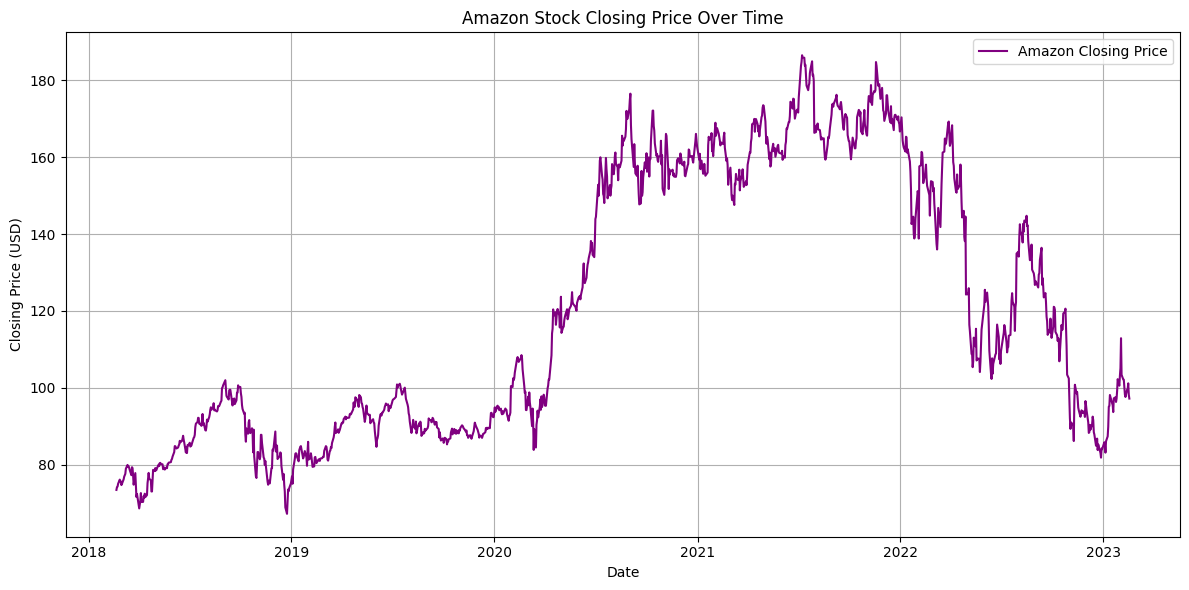

In [2]:
# -------------------------------
# Step 1: Import and Explore the Data
# -------------------------------
# Load Amazon stock data from CSV
amazon_data = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'])
amazon_data.set_index('Date', inplace=True)

# Extract the 'Close' column for analysis
amazon_close = amazon_data[['Close']]

# Visualize the historical closing prices
plt.figure(figsize=(12, 6))
plt.plot(amazon_close, color='purple', label='Amazon Closing Price')
plt.title('Amazon Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# -----------------------------------------
# Step 2: Stationarity Testing (ADF & KPSS)
# -----------------------------------------
# Apply Augmented Dickey-Fuller test to check for unit roots
adf_result = adfuller(amazon_close['Close'])

# Apply KPSS test to verify stationarity around a constant
kpss_result = kpss(amazon_close['Close'], regression='c', nlags="auto")

# Display p-values from both tests
print("ADF Test p-value:", adf_result[1])
print("KPSS Test p-value:", kpss_result[1])


ADF Test p-value: 0.45297105465166737
KPSS Test p-value: 0.01


<ipython-input-3-a137ca00612b>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(amazon_close['Close'], regression='c', nlags="auto")


In [4]:
# ------------------------------------------
# Step 3: Apply First-Order Differencing to Achieve Stationarity
# ------------------------------------------
# Compute first-order differences to remove trend
amazon_diff = amazon_close.diff().dropna()

# Re-run stationarity tests on differenced data
adf_diff_result = adfuller(amazon_diff['Close'])
kpss_diff_result = kpss(amazon_diff['Close'], regression='c', nlags="auto")

# Print updated test results
print("ADF p-value after Differencing:", adf_diff_result[1])
print("KPSS p-value after Differencing:", kpss_diff_result[1])


ADF p-value after Differencing: 0.0
KPSS p-value after Differencing: 0.1


<ipython-input-4-f74beabdf4e1>:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_diff_result = kpss(amazon_diff['Close'], regression='c', nlags="auto")


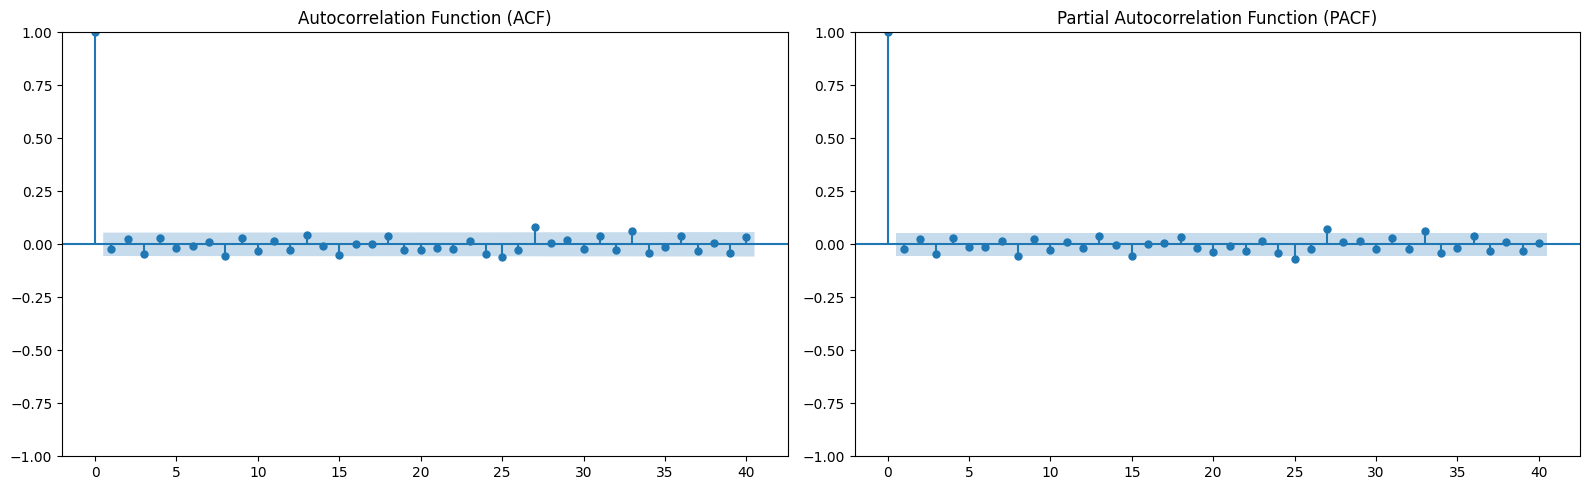

In [5]:
# -------------------------------------------------
# Step 4: Visualize ACF and PACF to Identify Lag Structure
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot Autocorrelation Function
plot_acf(amazon_diff, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Plot Partial Autocorrelation Function
plot_pacf(amazon_diff, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [6]:
# ----------------------------------------
# Step 5: Use Grid Search to Identify Optimal ARIMA Model
# ----------------------------------------
best_aic = np.inf
best_order = None
best_arima_model = None

# Explore combinations of AR (p) and MA (q) terms with fixed differencing (d=1)
for p in range(4):
    for q in range(4):
        try:
            model_candidate = ARIMA(amazon_close['Close'], order=(p, 1, q)).fit()
            if model_candidate.aic < best_aic:
                best_aic = model_candidate.aic
                best_order = (p, 1, q)
                best_arima_model = model_candidate
        except:
            continue

print("Optimal ARIMA configuration (p,d,q):", best_order)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal ARIMA configuration (p,d,q): (2, 1, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# ------------------------------------------------
# Step 6: Forecast Next 24 Months (~730 Days) Using the ARIMA Model
# ------------------------------------------------
forecast_result = best_arima_model.get_forecast(steps=730)
predicted_values_f = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Create a date index for the forecast horizon
last_date = amazon_close.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=730, freq='D')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [8]:
# ------------------------------------------------
# Step 7: Split Data for Validation and Evaluate In-Sample Forecast
# ------------------------------------------------
test_size = 24
train_data = amazon_close[:-test_size]
test_data = amazon_close[-test_size:]

# Fit ARIMA model on training subset
arima_trained = ARIMA(train_data['Close'], order=best_order).fit()

# Generate predictions for the test period
test_forecast = arima_trained.get_forecast(steps=test_size)
test_predicted_values = test_forecast.predicted_mean

# Extract actual and predicted values for evaluation
actual_values = test_data['Close'].values
predicted_values = test_predicted_values.values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [9]:
# -----------------------------------
# Step 8: Compute Forecast Accuracy Metrics
# -----------------------------------
mae_score = mean_absolute_error(actual_values, predicted_values)
rmse_score = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape_score = mean_absolute_percentage_error(actual_values, predicted_values)

print("ARIMA Model Evaluation on Test Set (Last 24 Days):")
print("MAE :", round(mae_score, 4))
print("RMSE:", round(rmse_score, 4))
print("MAPE:", round(mape_score, 4))


ARIMA Model Evaluation on Test Set (Last 24 Days):
MAE : 2.9318
RMSE: 4.2158
MAPE: 0.0285


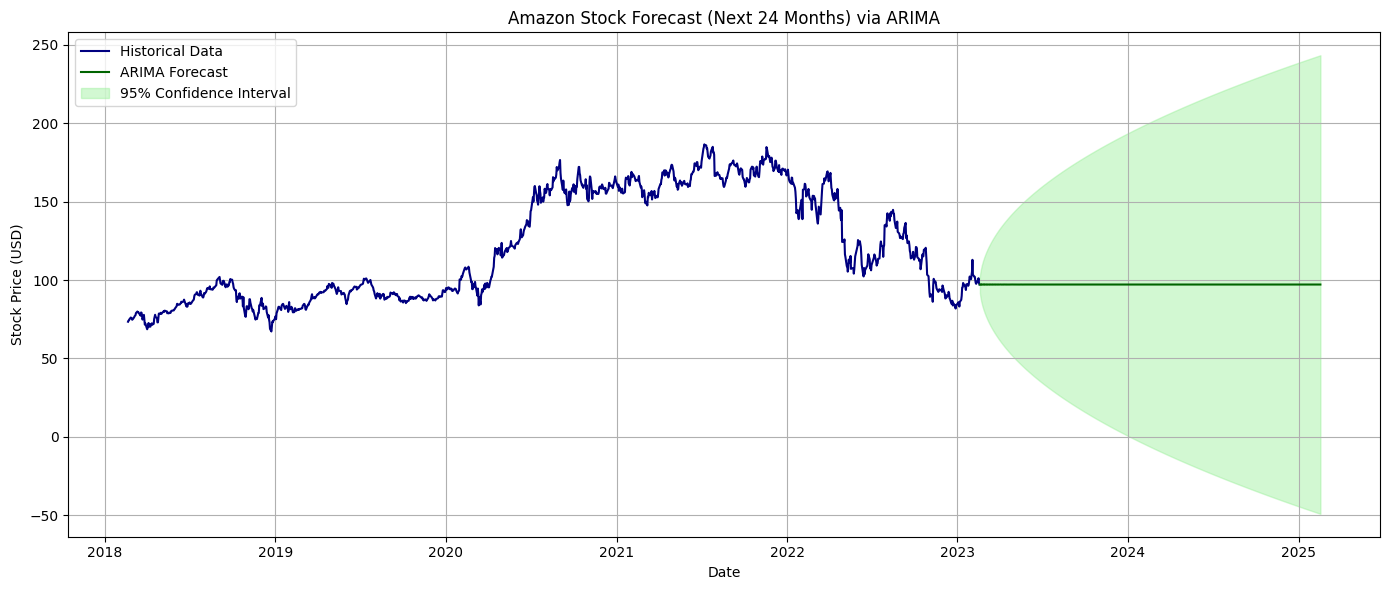

In [10]:
# -----------------------------------------
# Step 9: Visualize Forecast with Confidence Intervals
# -----------------------------------------
plt.figure(figsize=(14, 6))

# Plot historical closing prices
plt.plot(amazon_close.index, amazon_close['Close'], label='Historical Data', color='navy')

# Plot full future forecast (730 days)
plt.plot(future_dates, predicted_values_f, label='ARIMA Forecast', color='darkgreen')

# Plot forecast confidence intervals
plt.fill_between(future_dates,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='lightgreen', alpha=0.4, label='95% Confidence Interval')

plt.title('Amazon Stock Forecast (Next 24 Months) via ARIMA')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM and RNN Model

In [11]:
# -----------------------------------------
# Normalize Closing Prices for LSTM Input
# -----------------------------------------
scaler = MinMaxScaler()
amazon_scaled = amazon_close.copy()
amazon_scaled['Close'] = scaler.fit_transform(amazon_scaled[['Close']])


In [12]:
# -----------------------------------------
# Create Input Sequences for LSTM
# -----------------------------------------
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_len = 60  # Use past 60 days to predict the next
X, y = create_sequences(amazon_scaled['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

In [13]:
# -----------------------------------------
# Split into Training and Testing Sets
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [14]:
# -----------------------------------------
# Define and Train LSTM Model
# -----------------------------------------
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1161 - val_loss: 0.0069
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

In [15]:
# -----------------------------------------
# Plot Predictions vs Actual Values
# -----------------------------------------
def plot_predictions(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test)
    true_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_values = scaler.inverse_transform(predictions)

    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='Actual', color='navy')
    plt.plot(predicted_values, label='Predicted', color='seagreen')
    plt.title(f"{model_name} - Actual vs Predicted Stock Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


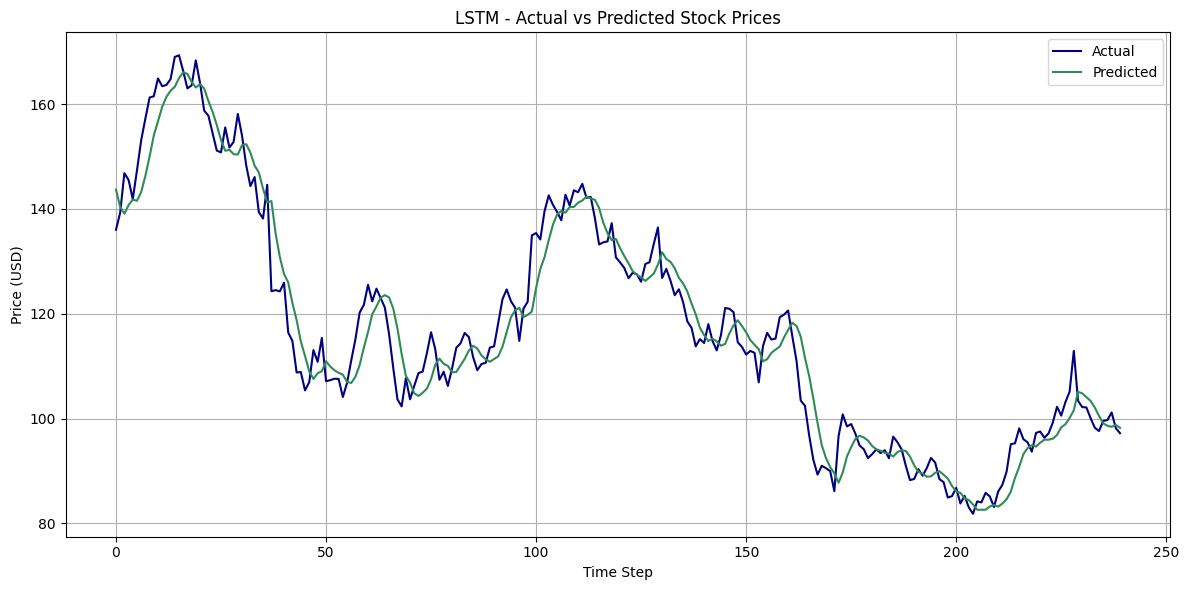

In [16]:
# Plot LSTM Test Predictions
plot_predictions(lstm_model, X_test, y_test, "LSTM")


In [17]:
# -----------------------------------------
# Evaluate Model Performance
# -----------------------------------------
lstm_preds_scaled = lstm_model.predict(X_test)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = scaler.inverse_transform(lstm_preds_scaled).flatten()

mae_lstm = mean_absolute_error(y_true, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred))
mape_lstm = mean_absolute_percentage_error(y_true, y_pred)

print("LSTM Model Performance:")
print("MAE :", round(mae_lstm, 4))
print("RMSE:", round(rmse_lstm, 4))
print("MAPE:", round(mape_lstm, 4))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Model Performance:
MAE : 4.0073
RMSE: 5.0896
MAPE: 0.0345


In [18]:
# -----------------------------------------
# Forecast Future Stock Prices (Next 504 Days)
# -----------------------------------------
def forecast_future(model, scaled_data, n_future=504, seq_len=60):
    last_sequence = scaled_data[-seq_len:].reshape(1, seq_len, 1)
    forecast_output = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence, verbose=0)[0][0]
        forecast_output.append(next_pred)
        last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

# Generate future forecast values
lstm_forecast = forecast_future(lstm_model, amazon_scaled['Close'].values, n_future=504)


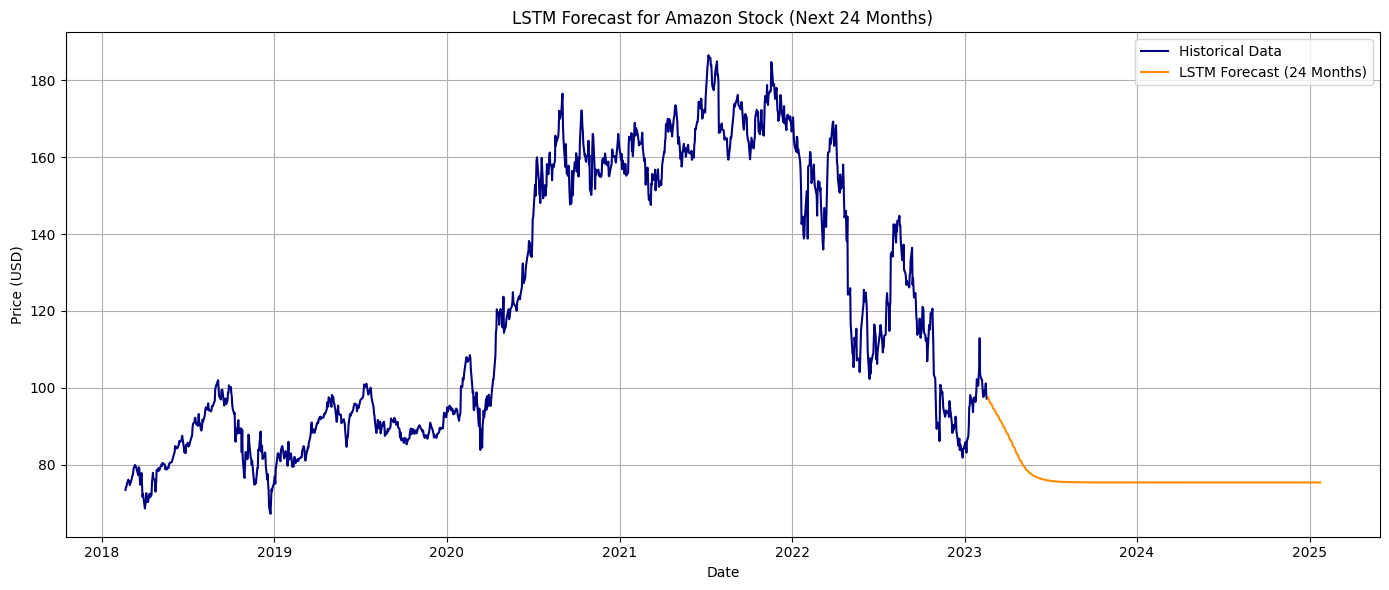

In [19]:
# -----------------------------------------
# Plot Full Forecast with Future Dates
# -----------------------------------------
future_index = pd.date_range(start=amazon_scaled.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')
historical_prices = scaler.inverse_transform(amazon_scaled['Close'].values.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(amazon_scaled.index, historical_prices, label='Historical Data', color='navy')
plt.plot(future_index, lstm_forecast, label='LSTM Forecast (24 Months)', color='darkorange')
plt.title('LSTM Forecast for Amazon Stock (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# -----------------------------------------
# Normalize Closing Prices
# -----------------------------------------
scaler = MinMaxScaler()
amazon_scaled = amazon_close.copy()
amazon_scaled['Close'] = scaler.fit_transform(amazon_scaled[['Close']])

In [21]:
# -----------------------------------------
# Create Sequences for Time Series Input
# -----------------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(amazon_scaled['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [22]:
# -----------------------------------------
# Train-Test Split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [23]:
# -----------------------------------------
# Define and Train GRU Model
# -----------------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [24]:
gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.1814 - val_loss: 0.0087
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0092 - val_loss: 0.0024
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1674e-04 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.6576e-04 - val_loss: 0.0019
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 7.1747e-04 - val_loss: 0.0017
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 7.0840e-04 - val_loss: 0.0017
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 6.7561e-04 - val_loss: 0.0016
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.9392e-04 - val_loss: 0.0017
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.0096e-04 - val_loss: 0.0016
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.9356e-04 - val_loss: 0.0015
Epoch 12/50
30/30 ━━━━━━━━━━━━━

In [ ]:
# -----------------------------------------
# Plot GRU Predictions vs True Values
# -----------------------------------------
def plot_predictions(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test)
    true_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_values = scaler.inverse_transform(predictions)

    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='Actual', color='navy')
    plt.plot(predicted_values, label='Predicted', color='teal')
    plt.title(f"{name} - Actual vs Predicted Stock Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize GRU Predictions
plot_predictions(gru_model, X_test, y_test, "GRU")


In [ ]:
# -----------------------------------------
# Evaluate GRU Performance
# -----------------------------------------
gru_preds_scaled = gru_model.predict(X_test)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = scaler.inverse_transform(gru_preds_scaled).flatten()

mae_gru = mean_absolute_error(y_true, y_pred)
rmse_gru = np.sqrt(mean_squared_error(y_true, y_pred))
mape_gru = mean_absolute_percentage_error(y_true, y_pred)

print("GRU Model Performance:")
print("MAE :", round(mae_gru, 4))
print("RMSE:", round(rmse_gru, 4))
print("MAPE:", round(mape_gru, 4))

In [ ]:
# -----------------------------------------
# Forecast Future Prices (504 Business Days)
# -----------------------------------------
def forecast_future(model, scaled_data, n_future=504, seq_len=60):
    last_seq = scaled_data[-seq_len:].reshape(1, seq_len, 1)
    future_preds = []

    for _ in range(n_future):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(next_pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Perform GRU Future Forecast
future_gru_forecast = forecast_future(gru_model, amazon_scaled['Close'].values, n_future=504)


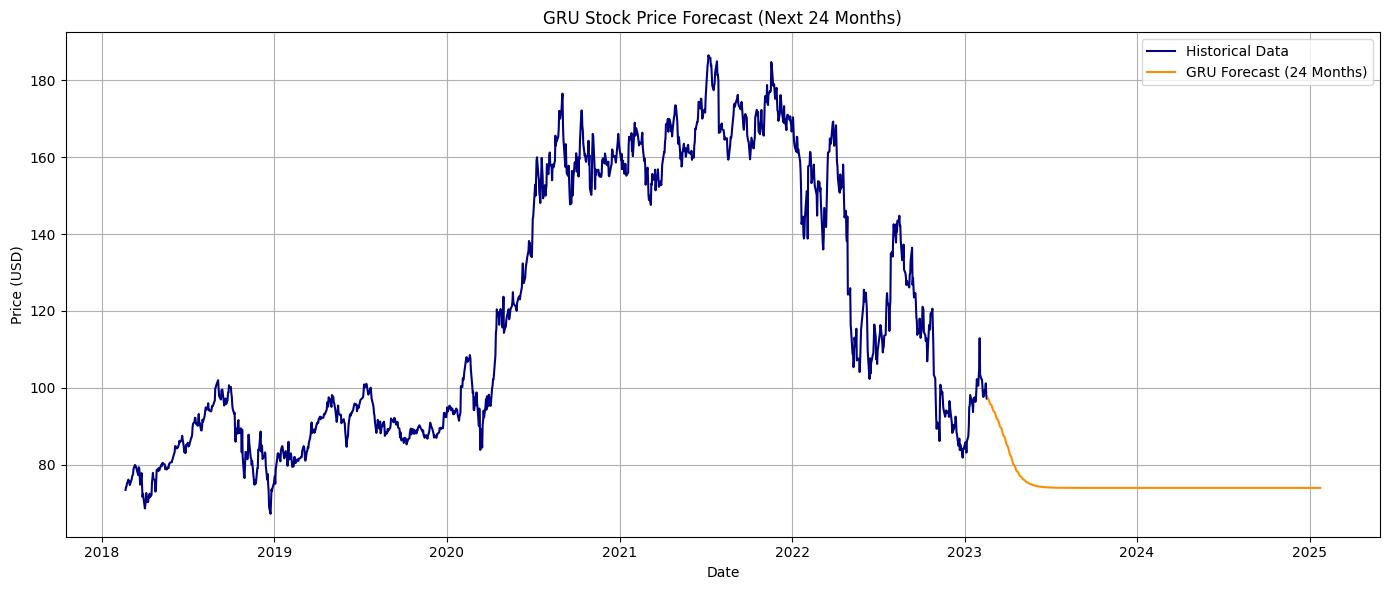

In [28]:
# -----------------------------------------
# Create Date Range and Plot Forecast
# -----------------------------------------
future_index = pd.date_range(start=amazon_scaled.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')
historical_prices = scaler.inverse_transform(amazon_scaled['Close'].values.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(amazon_scaled.index, historical_prices, label='Historical Data', color='navy')
plt.plot(future_index, future_gru_forecast, label='GRU Forecast (24 Months)', color='darkorange')
plt.title('GRU Stock Price Forecast (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Working on the JJ Dataset Now

In [31]:
dataset = pd.read_csv('/content/drive/MyDrive/jj.csv', index_col='date', parse_dates=True)
dataset.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


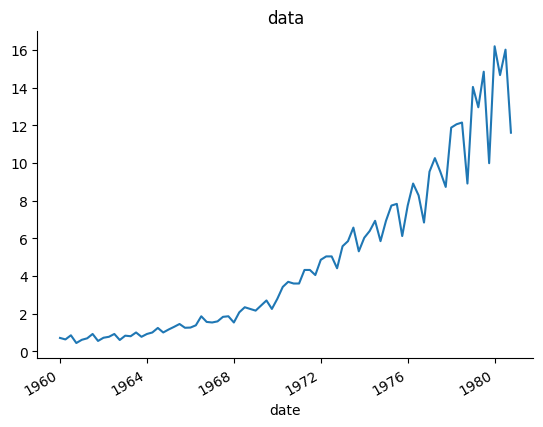

In [32]:
# Time Series Data
dataset['data'].plot(kind='line', title='data')
plt.gca().spines[['top', 'right']].set_visible(False)

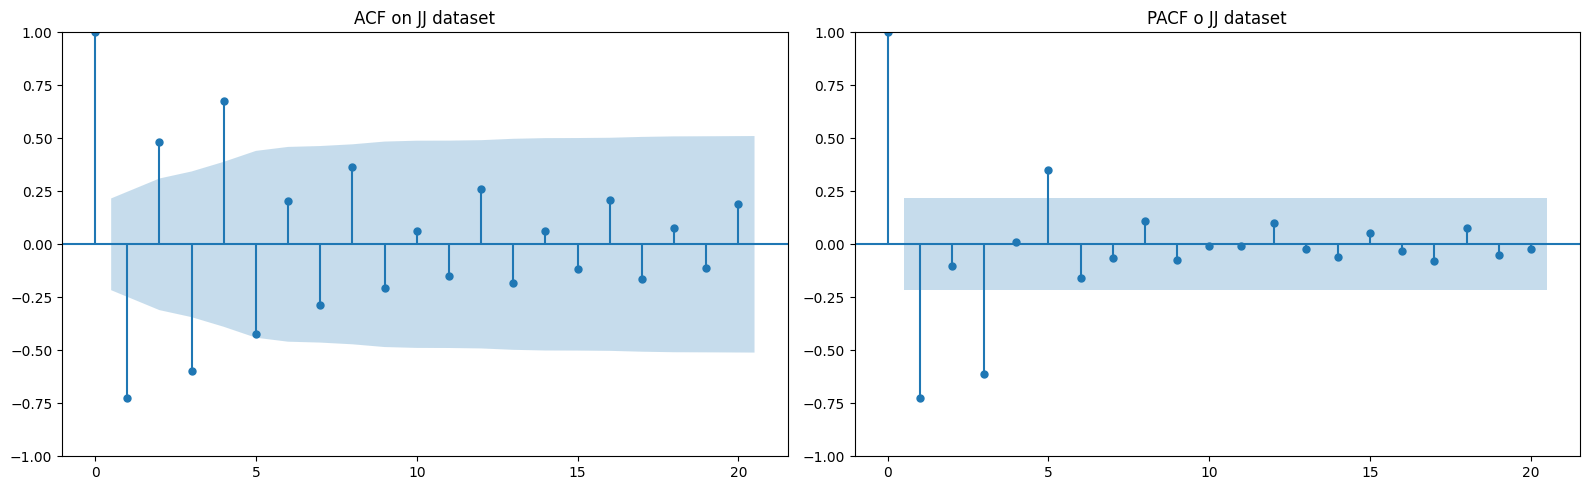

In [34]:
diff_data = dataset['data'].diff().dropna().diff().dropna()
#  ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_data, lags=20, ax=axes[0])
axes[0].set_title("ACF on JJ dataset")
plot_pacf(diff_data, lags=20, ax=axes[1])
axes[1].set_title("PACF o JJ dataset")
plt.tight_layout()
plt.show()

In [35]:
# -----------------------------------------------
# ARIMA Model Selection using Grid Search (p=0–3, d=2, q=0–3)
# -----------------------------------------------
lowest_aic = float("inf")
best_order = None
best_model = None

# Grid search over p and q with fixed d=2
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(dataset, order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                best_order = (p, 2, q)
                best_model = model
                lowest_aic = model.aic
        except:
            pass

print("Optimal ARIMA Order (p, d=2, q):", best_order)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal ARIMA Order (p, d=2, q): (3, 2, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# 3. Train/Test Split
# -----------------------------------------------
test_size = 24
train_data = dataset[:-test_size]
test_data = dataset[-test_size:]


In [40]:
# 4. Build and Fit Exponential Smoothing Model
# -----------------------------------------------
model = ExponentialSmoothing(
    train_data['data'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24
)
fitted_model = model.fit()

In [41]:
# 5. Forecast the Next 24 Months (Quarterly)
# -----------------------------------------------
forecast_steps = 24
forecast_index = pd.date_range(
    start=train_data.index[-1] + pd.DateOffset(months=3),
    periods=forecast_steps,
    freq='QS'  # Quarterly start
)

forecast = fitted_model.forecast(forecast_steps)
forecast = pd.Series(forecast.values, index=forecast_index, name='Forecast')

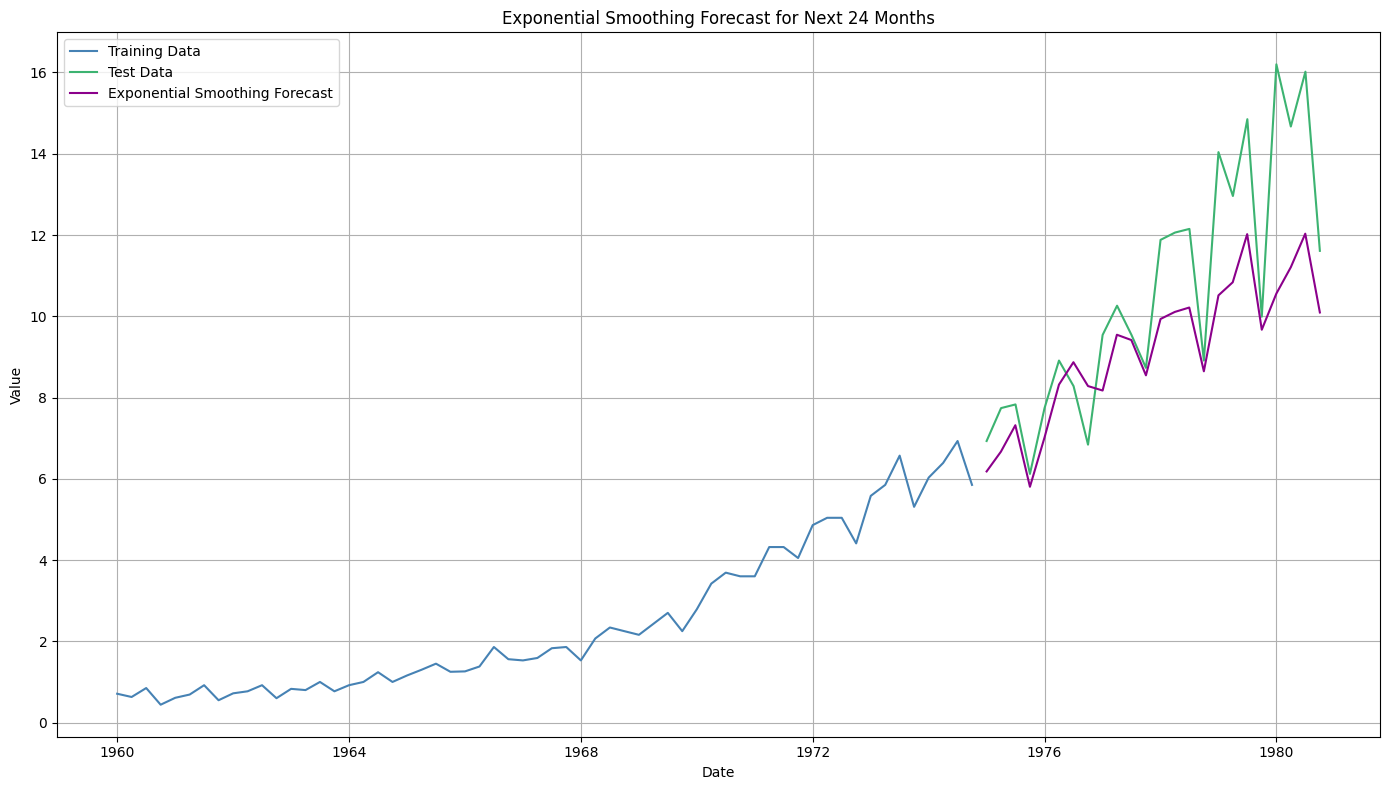

In [43]:
# -----------------------------------------------
# 6. Plot Training, Test, and Forecasted Data
# -----------------------------------------------
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data['data'], label='Training Data', color='steelblue')
plt.plot(test_data.index, test_data['data'], label='Test Data', color='mediumseagreen')
plt.plot(forecast.index, forecast, label='Exponential Smoothing Forecast', color='darkmagenta')
plt.title("Exponential Smoothing Forecast for Next 24 Months")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# 7. Evaluate Forecast Accuracy (on test overlap)
# -----------------------------------------------
eval_forecast = forecast[:len(test_data)]
mae = mean_absolute_error(test_data['data'], eval_forecast)
mse = mean_squared_error(test_data['data'], eval_forecast)
rmse = np.sqrt(mse)

print("Exponential Smoothing Model Performance:")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Exponential Smoothing Model Performance:
MAE : 1.5787
MSE : 4.4277
RMSE: 2.1042


# LSTM/GRU

In [45]:
# -----------------------------------------------
# Normalize the Target Column
# -----------------------------------------------
values = df[['data']].values.astype('float32')
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)

In [46]:
# -----------------------------------------------
# Convert Time Series to Supervised Format
# -----------------------------------------------

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df_data = DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(n_out):
        cols.append(df_data.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [49]:
# Use 6 past time steps
df_supervised = series_to_supervised(scaled_values, n_in=6, n_out=1)

# -----------------------------------------------
# Split into Features and Target
# -----------------------------------------------
X = df_supervised.iloc[:, :-1]
y = df_supervised.iloc[:, -1]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input to [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))


Epoch 1/50
8/8 - 5s - 588ms/step - loss: 0.0959 - val_loss: 0.3636
Epoch 2/50
8/8 - 0s - 19ms/step - loss: 0.0689 - val_loss: 0.2048
Epoch 3/50
8/8 - 0s - 39ms/step - loss: 0.0774 - val_loss: 0.1541
Epoch 4/50
8/8 - 0s - 36ms/step - loss: 0.0678 - val_loss: 0.1543
Epoch 5/50
8/8 - 0s - 38ms/step - loss: 0.0445 - val_loss: 0.1210
Epoch 6/50
8/8 - 0s - 19ms/step - loss: 0.0352 - val_loss: 0.1277
Epoch 7/50
8/8 - 0s - 18ms/step - loss: 0.0347 - val_loss: 0.1003
Epoch 8/50
8/8 - 0s - 20ms/step - loss: 0.0291 - val_loss: 0.0965
Epoch 9/50
8/8 - 0s - 35ms/step - loss: 0.0320 - val_loss: 0.1001
Epoch 10/50
8/8 - 0s - 37ms/step - loss: 0.0332 - val_loss: 0.1000
Epoch 11/50
8/8 - 0s - 31ms/step - loss: 0.0305 - val_loss: 0.0975
Epoch 12/50
8/8 - 0s - 40ms/step - loss: 0.0244 - val_loss: 0.0958
Epoch 13/50
8/8 - 0s - 37ms/step - loss: 0.0341 - val_loss: 0.0969
Epoch 14/50
8/8 - 0s - 38ms/step - loss: 0.0306 - val_loss: 0.1114
Epoch 15/50
8/8 - 0s - 28ms/step - loss: 0.0244 - val_loss: 0.1014
Epo

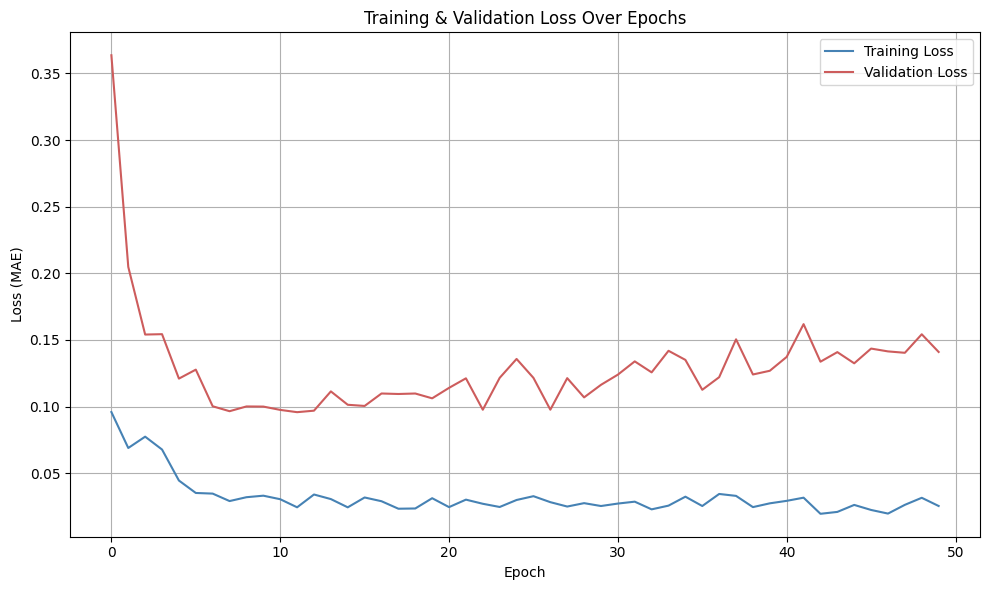

In [55]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mae', optimizer=Adam())

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -----------------------------------------------
# Plot Training History
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='indianred')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# -----------------------------------------------
# Forecast 24 Quarters Ahead
# -----------------------------------------------
last_seq = scaled_values[-6:]
forecast_scaled = []

for _ in range(24):
    input_seq = last_seq.reshape((1, 6, 1))
    next_val = model.predict(input_seq, verbose=0)
    forecast_scaled.append(next_val[0, 0])
    last_seq = np.append(last_seq[1:], [[next_val[0, 0]]], axis=0)

forecast_inv = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

In [57]:
# -----------------------------------------------
# Build Forecast DataFrame
# -----------------------------------------------
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=24, freq='Q')
forecast_df = pd.DataFrame(forecast_inv, index=forecast_index, columns=['Forecast'])

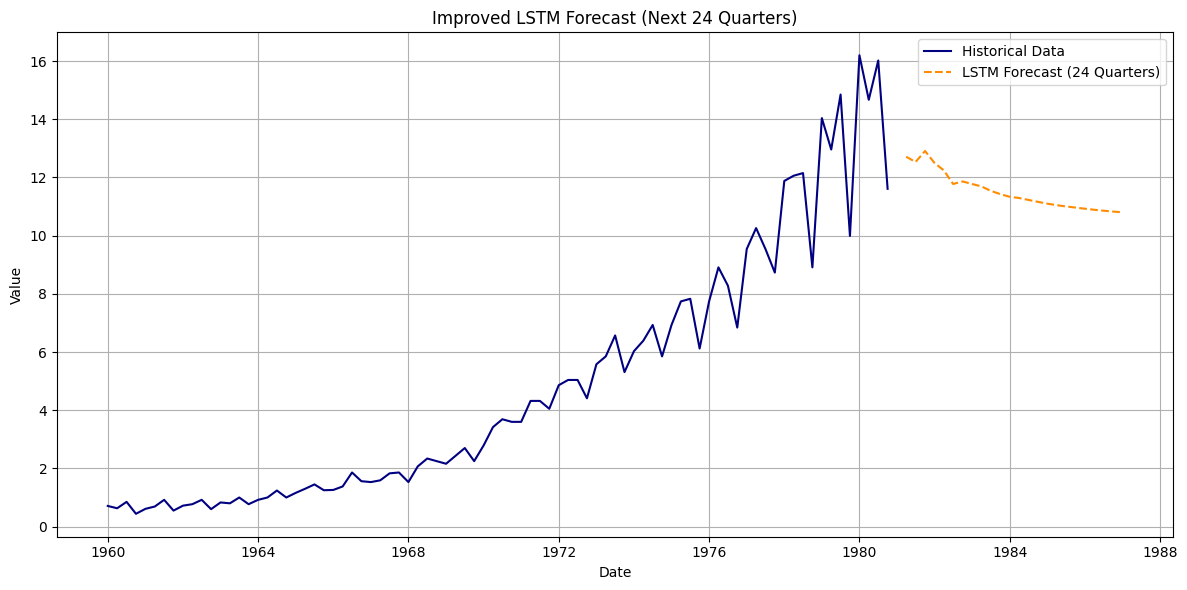

In [58]:
# -----------------------------------------------
# Plot Forecast vs Historical
# -----------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['data'], label='Historical Data', color='navy')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM Forecast (24 Quarters)', color='darkorange', linestyle='--')
plt.title('Improved LSTM Forecast (Next 24 Quarters)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# -----------------------------------------------
# Evaluate Model on Test Set
# -----------------------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print("Improved LSTM Model Performance:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Improved LSTM Model Performance:
MAE  : 2.2221
MSE  : 6.2032
RMSE : 2.4906
R²   : -0.0602
